In [1]:
import xarray as xr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from glob import glob
import tqdm
from preprocessing_modules import find_nearest_pixelcoods

In [2]:
path = '/pd/data/CML/seviri/nc/2020'

## Open and concat datasets per month

In [3]:
%%time
# alternative approach for opening many and large datasets
# from https://lightrun.com/answers/pydata-xarray-slow-performance-with-open_mfdataset
from glob import glob
datasets = [xr.open_dataset(fname, chunks={}) for fname in sorted(glob(str(path+'/06/*.nc')))]
ds_sev_06 = xr.concat(datasets, dim='time')

CPU times: user 4min 16s, sys: 1min 9s, total: 5min 25s
Wall time: 12min 2s


In [50]:
ds_sev_06.nbytes/1e9

3467.827881288

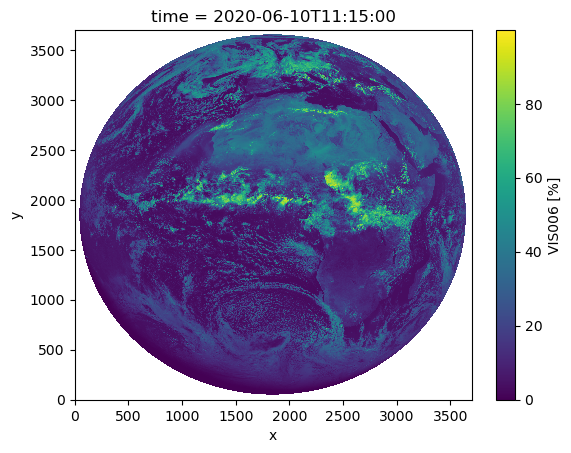

In [8]:
ds_sev_06.sel(time='2020-06-10T11:15:00.000000000').VIS006.plot()

In [7]:
old_eg = xr.open_dataset('/pd/home/wiegels-r/test/msg_seviri_wet_dry/data/ds_seviri_cut.nc')
old_eg

<xarray.Dataset>
Dimensions:     (time: 2970, y: 180, x: 252)
Coordinates:
  * time        (time) datetime64[ns] 2021-05-01T00:15:00 ... 2021-06-01
    LON         (y, x) float64 ...
    LAT         (y, x) float64 ...
Dimensions without coordinates: y, x
Data variables: (12/13)
    IR_016      (time, y, x) float64 ...
    IR_039      (time, y, x) float64 ...
    IR_087      (time, y, x) float64 ...
    IR_097      (time, y, x) float64 ...
    IR_108      (time, y, x) float64 ...
    IR_120      (time, y, x) float64 ...
    ...          ...
    VIS006      (time, y, x) float64 ...
    VIS008      (time, y, x) float64 ...
    WV_062      (time, y, x) float64 ...
    WV_073      (time, y, x) float64 ...
    longitudes  (y, x) float64 ...
    latitudes   (y, x) float64 ...

## Find pixel coordinates that can be used for all SEVIRI dataset to cut to area of Germany

In [12]:
# set lat/lon min and amx for Germany extent
lat_min = np.min(old_eg.LAT.values)
lat_max = np.max(old_eg.LAT.values)
lon_min = np.min(old_eg.LON.values)
lon_max = np.max(old_eg.LON.values)

[yloc_min], [xloc_min] = find_nearest_pixelcoods(lat_min, lon_min, ds_eg.LAT.values, ds_eg.LON.values) # NOTE: Function cannot handle nans --> nans of lat/lon array must be excluded /cut out before hand 
[yloc_max], [xloc_max] = find_nearest_pixelcoods(lat_max, lon_max, ds_eg.LAT.values, ds_eg.LON.values)
print(xloc_min, yloc_min, xloc_max, yloc_max)

438 789 689 968


In [13]:
# Must be dividable by 6 and 9: y: +1 = 180 and x:+1 = 252
xloc_min = xloc_min -1
yloc_min = yloc_min -1 


In [14]:
print(xloc_min, yloc_min, xloc_max, yloc_max)

437 788 689 968


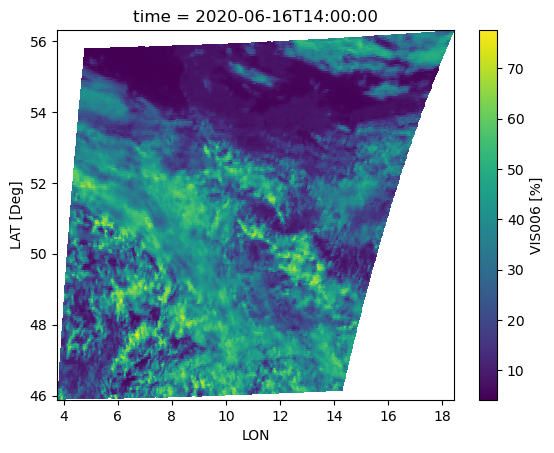

In [15]:
ds_de_eg = ds_eg.sel(x=slice(xloc_min, xloc_max), y=slice(yloc_min, yloc_max))
ds_de_eg.isel(time=3).VIS006.plot(x='LON', y='LAT')

## Cut to Germany extent and save to zarr archive

In [14]:
# only use a slice without nans, to find extent of Burkina Faso
ds_sev_06 = ds_sev_06.sel(x=slice(1500,2500), y=slice(2500,3500))
# then actually slice to Germany extent
ds_de_06 = ds_sev_06.sel(x=slice(xloc_min, xloc_max), y=slice(yloc_min, yloc_max))
ds_de_06

<xarray.Dataset>
Dimensions:  (y: 180, x: 252, time: 2880)
Coordinates:
    LON      (y, x) float32 3.79 3.84 3.88 3.92 3.96 ... 18.21 18.26 18.32 18.38
    LAT      (y, x) float32 45.91 45.91 45.91 45.91 ... 56.26 56.26 56.27 56.27
  * time     (time) datetime64[ns] 2020-06-01T00:15:00 ... 2020-07-01
Dimensions without coordinates: y, x
Data variables:
    IR_016   (time, y, x) float64 dask.array<chunksize=(4, 180, 252), meta=np.ndarray>
    IR_039   (time, y, x) float64 dask.array<chunksize=(4, 180, 252), meta=np.ndarray>
    IR_087   (time, y, x) float64 dask.array<chunksize=(4, 180, 252), meta=np.ndarray>
    IR_097   (time, y, x) float64 dask.array<chunksize=(4, 180, 252), meta=np.ndarray>
    IR_108   (time, y, x) float64 dask.array<chunksize=(4, 180, 252), meta=np.ndarray>
    IR_120   (time, y, x) float64 dask.array<chunksize=(4, 180, 252), meta=np.ndarray>
    IR_134   (time, y, x) float64 dask.array<chunksize=(4, 180, 252), meta=np.ndarray>
    VIS006   (time, y, x) float64 dask.array<chunksize=(4, 180, 252), meta=np.ndarray>
    VIS008   (time, y, x) float64 dask.array<chunksize=(4, 180, 252), meta=np.ndarray>
    WV_062   (time, y, x) float64 dask.array<chunksize=(4, 180, 252), meta=np.ndarray>
    WV_073   (time, y, x) float64 dask.array<chunksize=(4, 180, 252), meta=np.ndarray>
Attributes:
    description:  coords with matrices

In [16]:
%%time
# save prepared dataset to new folder
tempdir = '/pd/data/CML/seviri/test_wiegels/DE_06.zarr'
ds_de_06.to_zarr(tempdir)

CPU times: user 2h 25min 28s, sys: 1h 4min 45s, total: 3h 30min 14s
Wall time: 1h 58min 37s
